# component magnitude checks


In [1]:
import os
os.environ['PROJ_LIB'] = '/home/brogalla/anaconda3/share/proj'

In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
from itertools import compress
import datetime as dt

%matplotlib notebook

In [4]:
import sys
sys.path.insert(0, '/ocean/brogalla/GEOTRACES/analysis-brogalla/modules')
import ariane as ar

In [5]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

Load domain dimensions

In [6]:
mask  = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask = np.array(mask.variables['tmask'])
cond  = (tmask[0,:,:,:] > 0.1) 
land_mask = np.ma.masked_where(cond, tmask[0,:,:,:]) 
tmask     = tmask[0,:,1480:2180,160:800]
tmask_full    = np.empty((12,50,700,640))
tmask_full[:] = tmask

In [7]:
ref   = nc.Dataset('/data/brogalla/run_storage/Mn-set1-201910/ref-2015/ANHA12_EXH006_2015_monthly.nc',  'r')
tlons = np.array(ref.variables['nav_lon'])
tlats = np.array(ref.variables['nav_lat'])
depth = np.array(ref.variables['deptht'])

In [8]:
# Load structure from sample dataset:
ref   = nc.Dataset('/data/brogalla/ANHA12/ANHA12-EXH006_5d_gridT_y2015m01d05.nc',  'r')
lat_model = ref.variables['nav_lat'][1480:2180, 160:800]
lon_model = ref.variables['nav_lon'][1480:2180, 160:800]

Load Mn model run results

In [9]:
def load_results(folder_ref, year):
    
    dmn_riv = np.empty((12,700,640))
    dmn_sed = np.empty((12,700,640))
    dmn_atm = np.empty((12,700,640))
    dmn_ice = np.empty((12,700,640))
    dmn_red = np.empty((12,50,700,640))
    dmn_oxi = np.empty((12,50,700,640))
    
    months  = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
    
    i=0
    for month in months:
        file_comp = 'ANHA12_EXH006_1m_'+year+'0101_'+year+'1231_comp_'+year+month+'-'+year+month+'.nc'
        monthly   = nc.Dataset(folder_ref+file_comp)
        
        dmn_riv[i,:,:] = np.array(monthly.variables['dmnriv'])[0,:,:]
        dmn_sed[i,:,:] = np.array(monthly.variables['dmnsed'])[0,:,:]
        dmn_atm[i,:,:] = np.array(monthly.variables['dmnatm'])[0,:,:]
        dmn_ice[i,:,:] = np.array(monthly.variables['dmnice'])[0,:,:]
        dmn_red[i,:,:,:] = np.array(monthly.variables['dmnred'])[:,:,:]
        dmn_oxi[i,:,:,:] = np.array(monthly.variables['dmnoxi'])[:,:,:]
        
        i+=1
        
    dmn_riv = np.ma.masked_where((tmask_full[:,0,:,:] < 0.1), dmn_riv)
    dmn_sed = np.ma.masked_where((tmask_full[:,0,:,:] < 0.1), dmn_sed)
    dmn_atm = np.ma.masked_where((tmask_full[:,0,:,:] < 0.1), dmn_atm)
    dmn_ice = np.ma.masked_where((tmask_full[:,0,:,:] < 0.1), dmn_ice)
    dmn_red = np.ma.masked_where((tmask_full < 0.1), dmn_red)
    dmn_oxi = np.ma.masked_where((tmask_full < 0.1), dmn_oxi)
    
    return dmn_riv, dmn_sed, dmn_atm, dmn_ice, dmn_red, dmn_oxi

In [10]:
folder_spinup2  = '/data/brogalla/run_storage/spin-up2/'

In [11]:
dmn_riv, dmn_sed, dmn_atm, dmn_ice, dmn_red, dmn_oxi = load_results(folder_spinup2, '2002')

Volume of grid cells

In [12]:
imin, imax = 1480, 2180
jmin, jmax = 160, 800

In [13]:
e1t_base = np.array(mask.variables['e1t'])[0,imin:imax,jmin:jmax]
e2t_base = np.array(mask.variables['e2t'])[0,imin:imax,jmin:jmax]
e3t = np.array(mask.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]

In [14]:
e1t    = np.tile(e1t_base, (50,1,1))
e2t    = np.tile(e2t_base, (50,1,1))

In [15]:
volume3d  = e1t*e2t*e3t
area      = e1t_base*e2t_base

In [16]:
volume_month    = np.full((12,50,700,640),volume3d)

In [17]:
atm  = dmn_atm*1e3*1e6*24*3600*30*e3t[0,:,:]
riv  = dmn_riv*1e3*1e6*24*3600*30*e3t[0,:,:]
sed  = dmn_sed*1e3*1e6*24*3600*30*e3t[0,:,:]
ice  = dmn_ice*1e3*1e6*24*3600*30*e3t[0,:,:]
red  = dmn_red*1e3*1e6*24*3600*30*e3t
oxi  = dmn_oxi*1e3*1e6*24*3600*30*e3t

## Mn model component contributions to the water column

Oxidation and reduction are integrated through the column

In [19]:
red_int = red.sum(axis=1)
oxi_int = oxi.sum(axis=1)

In [34]:
riv_year = riv.sum(axis=0)
sed_year = sed.sum(axis=0)
atm_year = atm.sum(axis=0)
ice_year = ice.sum(axis=0)
red_year = red_int.sum(axis=0)
oxi_year = oxi_int.sum(axis=0)

print('Mean contribution [micromol/m2/yr]')
print('-----------------------------------')
print('River:      ', "{0:.1f}".format(riv_year.mean()))
print('Sediment:   ', "{0:.2f}".format(sed_year.mean()))
print('Atmosphere: ', "{0:.2f}".format(atm_year.mean()))
print('Ice:        ', "{0:.2f}".format(ice_year.mean()))
print('-----------------------------------')
print('Reduction:  ', "{0:.0f}".format(red_year.mean()))
print('Oxidation:  ', "{0:.0f}".format(oxi_year.mean()))
print('-----------------------------------')
print('Sum:        ',"{0:.0f}".format((riv_year+sed_year+atm_year+ice_year+red_year-oxi_year).mean()))

Mean contribution [micromol/m2/yr]
-----------------------------------
River:       10.3
Sediment:    4.48
Atmosphere:  0.00
Ice:         0.07
-----------------------------------
Reduction:   12060
Oxidation:   15147
-----------------------------------
Sum:         -3072


Net loss of Mn in the water column as a result of oxidation. However, this sum does not take into account advection and diffusion.

|    Component          | Van Hulten model         | My model average (forcing)    |
|:----------------------|:-------------------------|:------------------------------|
| Dust deposition rate  | 0-0.3 g/m$^2$/yr         | 1e-5 g/m$^2$/yr               |
| Ice dust release rate |      NA                  | 0.2  g/m$^2$/yr               |
|                                                                                  |
| Mn from atmosphere    | 0-3 $\mu$mol/m$^2$/yr    | 3e-4 $\mu$mol/m$^2$/yr        |
| Mn from ice           |      NA                  | 0.07 $\mu$mol/m$^2$/yr        |
| Mn from sediments     | 0-70 $\mu$mol/m$^2$/yr   | 4    $\mu$mol/m$^2$/yr        |
| Mn from rivers        | 0.3-18 $\mu$mol/m$^2$/yr | 10   $\mu$mol/m$^2$/yr        |

Atmospheric forcing is similar between this model and Van Hulten (if we combine the dust from atmosphere and ice). The Mn combined contribution from the atmosphere is on the low end in this model.

Sedimentary and river contributions are also similar order of magnitude.

## Spatial/temporal plots of components

In [54]:
width = 0.5

colors = ['#ccb598', '#007378', '#739f78', '#cc7722', '#cee7fd'] # dust, rivers, scavenging, sediment diffusion

months = ['Jan','Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

In [21]:
def plot_layer(riv, sed, atm, ice, red, oxi):
    
    # calculate the sum:
    riv_ave = np.sum(np.divide(riv, area), axis=(1,2)) # per m2
    sed_ave = np.sum(np.divide(sed, area), axis=(1,2)) 
    atm_ave = np.sum(np.divide(atm, area), axis=(1,2)) 
    ice_ave = np.sum(np.divide(ice, area), axis=(1,2)) 
    red_ave = np.sum(np.divide(red, area), axis=(1,2)) 
    oxi_ave = np.sum(np.divide(oxi, area), axis=(1,2))
    
    fig, ax = plt.subplots(figsize=(9,4))

    for i in range(0,12):
        ax.bar(months[i], red_ave[i], width                                                    , color=colors[2])
        ax.bar(months[i], atm_ave[i], width, bottom=red_ave[i]                                 , color=colors[0])
        ax.bar(months[i], riv_ave[i], width, bottom=atm_ave[i]+red_ave[i]                      , color=colors[1])
        ax.bar(months[i], sed_ave[i], width, bottom=atm_ave[i]+riv_ave[i]+red_ave[i]           , color=colors[3])
        ax.bar(months[i], ice_ave[i], width, bottom=atm_ave[i]+riv_ave[i]+sed_ave[i]+red_ave[i], color=colors[4])
        
        # Oxidation should be a sink so negative
        ax.bar(months[i], -1*oxi_ave[i], width, bottom=0, color='gray')
            
    # for legend:
    ax.bar(months[0], atm_ave[0], 0, color=colors[0], label='Dust')
    ax.bar(months[0], riv_ave[0], 0, color=colors[1], label='Riverine')
    ax.bar(months[0], sed_ave[0], 0, color=colors[3], label='Sediment resuspension')
    ax.bar(months[0], ice_ave[0], 0, color=colors[4], label='Ice')
    ax.bar(months[0], red_ave[0], 0, color=colors[2], label='Reduction')
    ax.bar(months[0], oxi_ave[0], 0, color='gray'   , label='Oxidation')
    
    ax.legend(loc=(1.03,0.05), frameon=False)
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin-0.0001, ymax+0.0001])    
    ax.plot([xmin, xmax],[0, 0],'-k',linewidth=1)
        
    ax.set_ylabel('Monthly contribution [moles of Mn / m2]')
    
    return

<IPython.core.display.Javascript object>


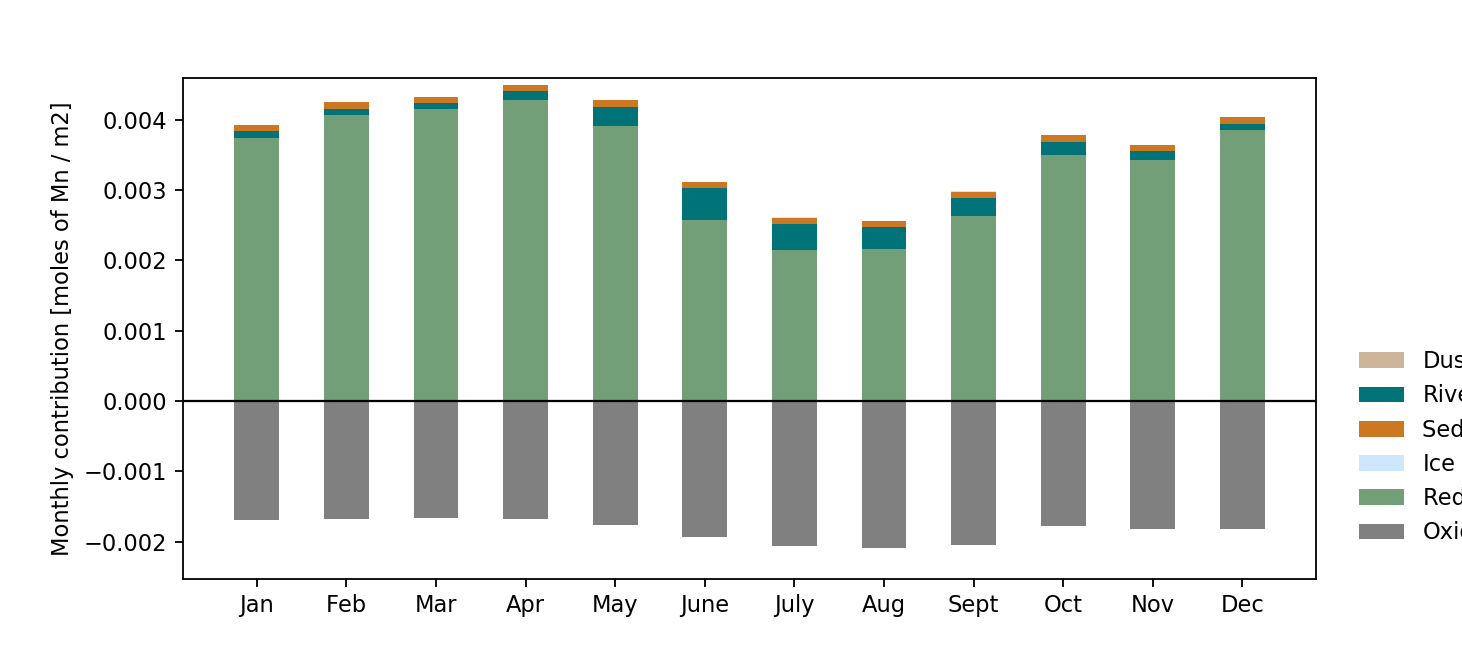

In [22]:
plot_layer(riv, sed, atm, ice, red[:,0,:,:], oxi[:,0,:,:])

<IPython.core.display.Javascript object>


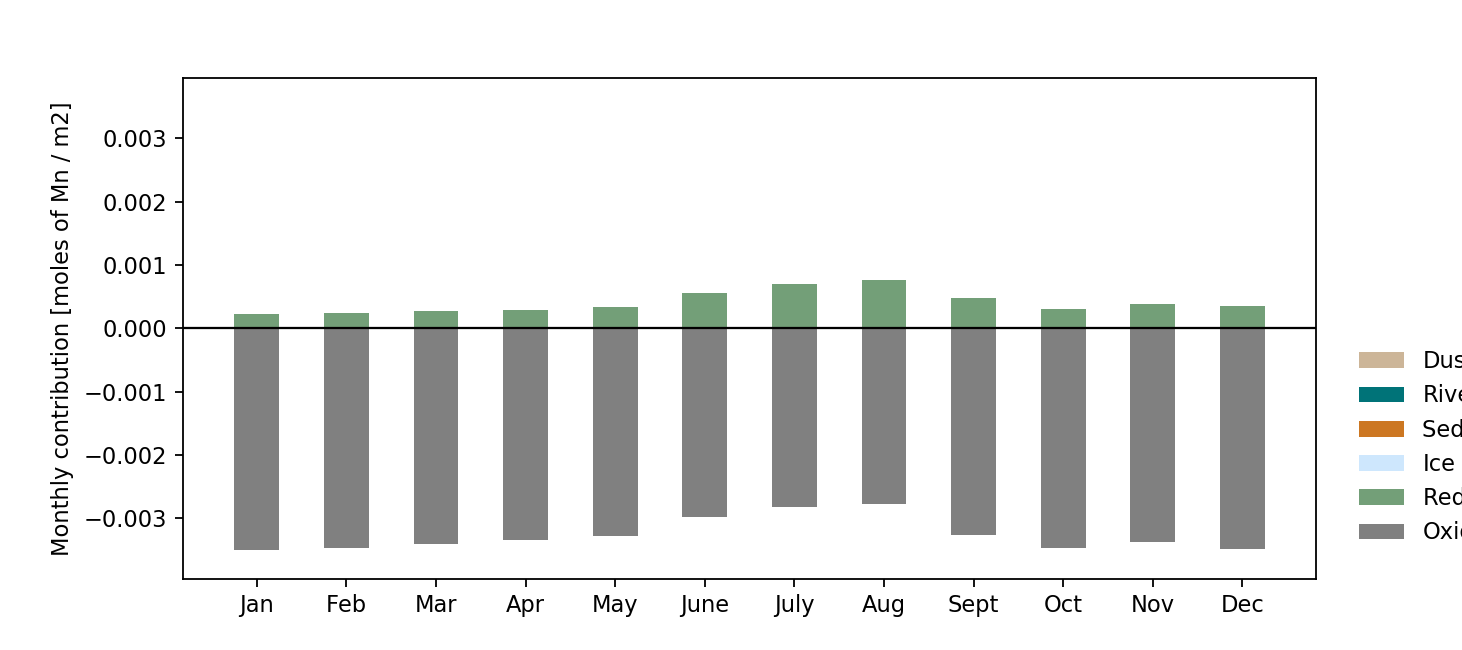

In [23]:
plot_layer(np.zeros(riv.shape), np.zeros(sed.shape), np.zeros(atm.shape), np.zeros(ice.shape), \
           red[:,10,:,:], oxi[:,10,:,:])

<IPython.core.display.Javascript object>


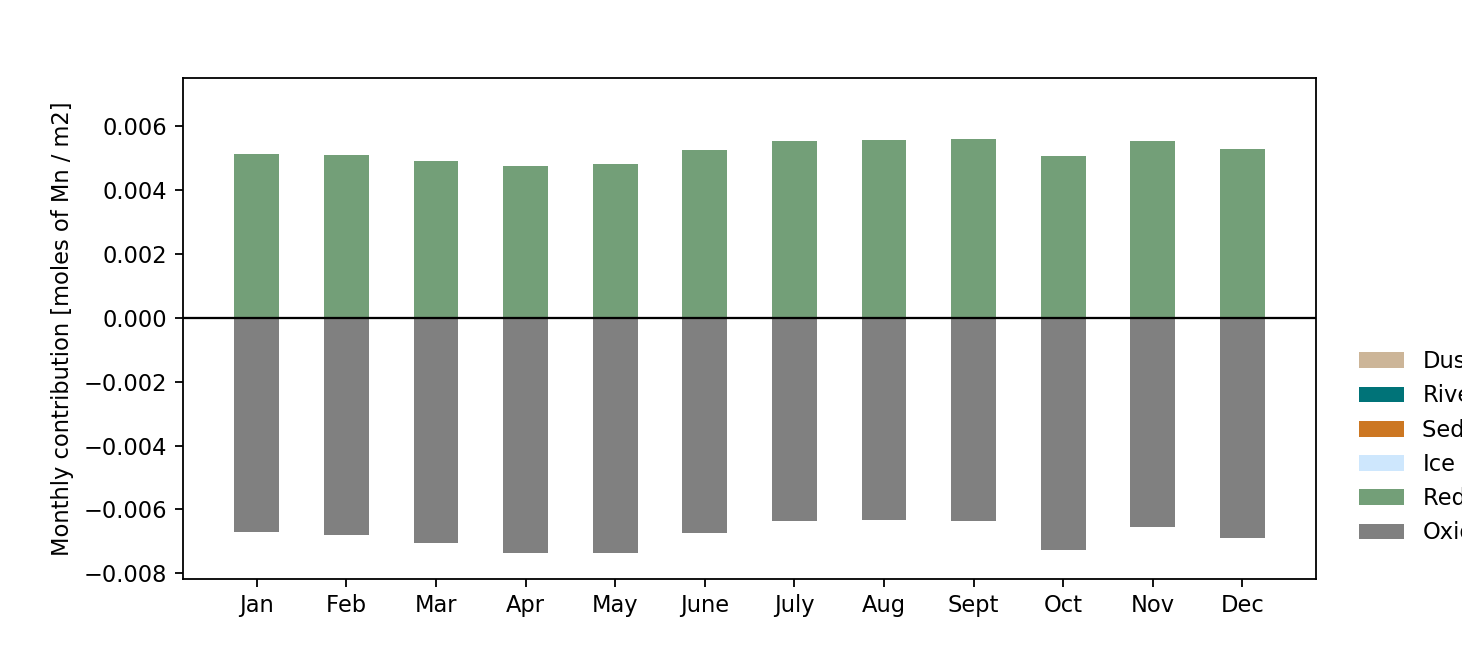

In [24]:
plot_layer(np.zeros(riv.shape), np.zeros(sed.shape), np.zeros(atm.shape), np.zeros(ice.shape), \
           red[:,20,:,:], oxi[:,20,:,:])

Then, look at how these contributions changed with time. 

In [39]:
ts_riv = np.sum(riv, axis=(1,2))
ts_sed = np.sum(sed, axis=(1,2))
ts_atm = np.sum(atm, axis=(1,2))
ts_ice = np.sum(ice, axis=(1,2))
ts_red = np.sum(red_int, axis=(1,2))
ts_oxi = np.sum(oxi_int, axis=(1,2))    

<IPython.core.display.Javascript object>


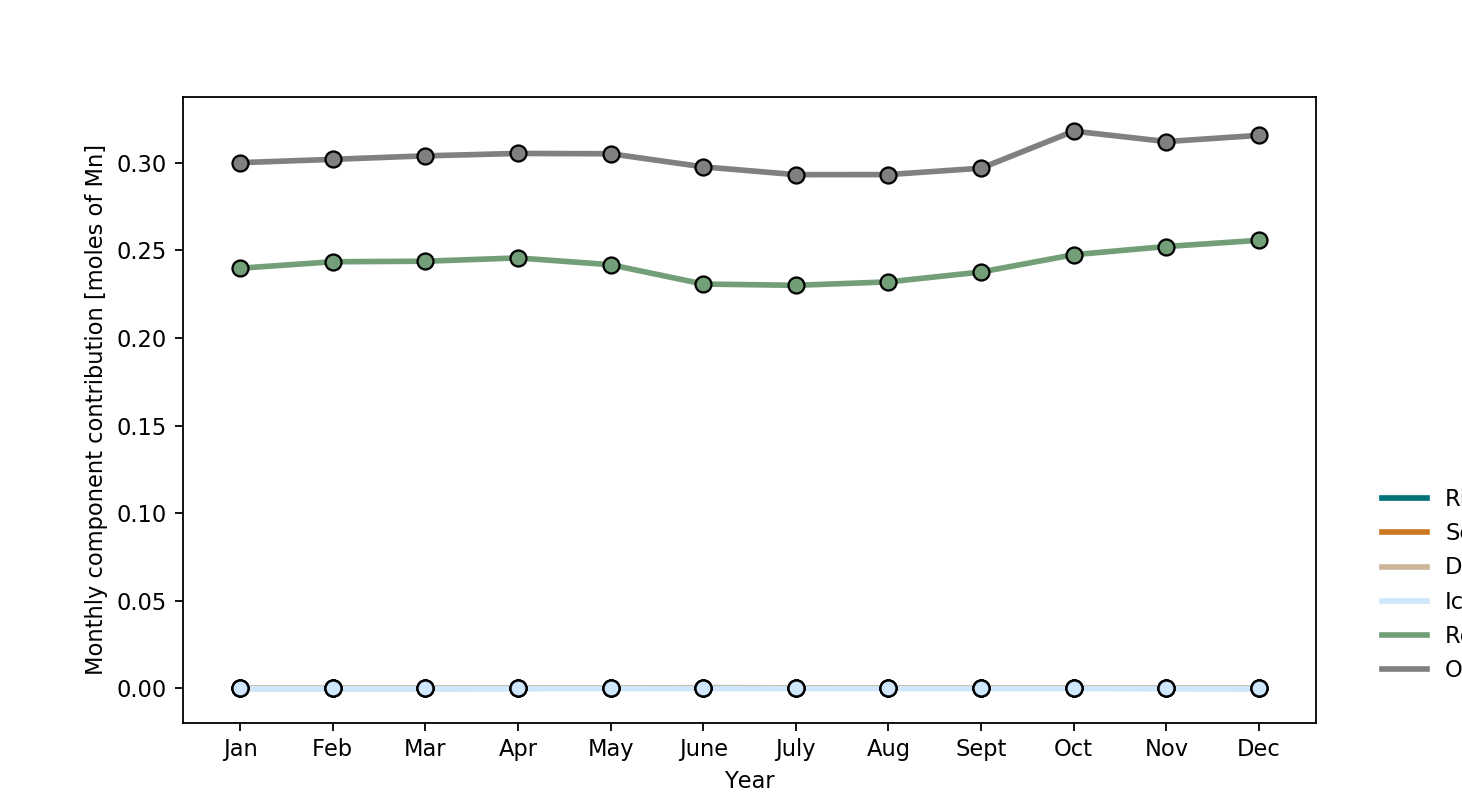

Text(0, 0.5, 'Monthly component contribution [moles of Mn]')

In [40]:
fig, ax = plt.subplots(1,1, figsize=(9,5))

ax.plot(months, ts_riv, color=colors[1], linewidth=2.5, label='Riverine'   , zorder=1)
ax.plot(months, ts_sed, color=colors[3], linewidth=2.5, label='Sedimentary', zorder=1)
ax.plot(months, ts_atm, color=colors[0], linewidth=2.5, label='Dust'       , zorder=1)
ax.plot(months, ts_ice, color=colors[4], linewidth=2.5, label='Ice'        , zorder=1)
ax.plot(months, ts_red, color=colors[2], linewidth=2.5, label='Reduction'  , zorder=1)
ax.plot(months, ts_oxi, color='gray'   , linewidth=2.5, label='Oxidation'  , zorder=1)

ax.scatter(months, ts_riv, color=colors[1], edgecolor='k', s=50, zorder=2)
ax.scatter(months, ts_sed, color=colors[3], edgecolor='k', s=50, zorder=2)
ax.scatter(months, ts_atm, color=colors[0], edgecolor='k', s=50, zorder=2)
ax.scatter(months, ts_ice, color=colors[4], edgecolor='k', s=50, zorder=2)
ax.scatter(months, ts_red, color=colors[2], edgecolor='k', s=50, zorder=2)
ax.scatter(months, ts_oxi, color='gray'   , edgecolor='k', s=50, zorder=2)

ax.legend(loc=(1.05, 0.05), frameon=False)
ax.set_xlabel('Year')
ax.set_ylabel('Monthly component contribution [moles of Mn / m2]')

In [64]:
flux_balance = riv + sed + atm + ice + red_int - oxi_int

In [66]:
total_balance   = np.sum(flux_balance, axis=(1,2))
average_balance = np.average(flux_balance, axis=(1,2))

<IPython.core.display.Javascript object>


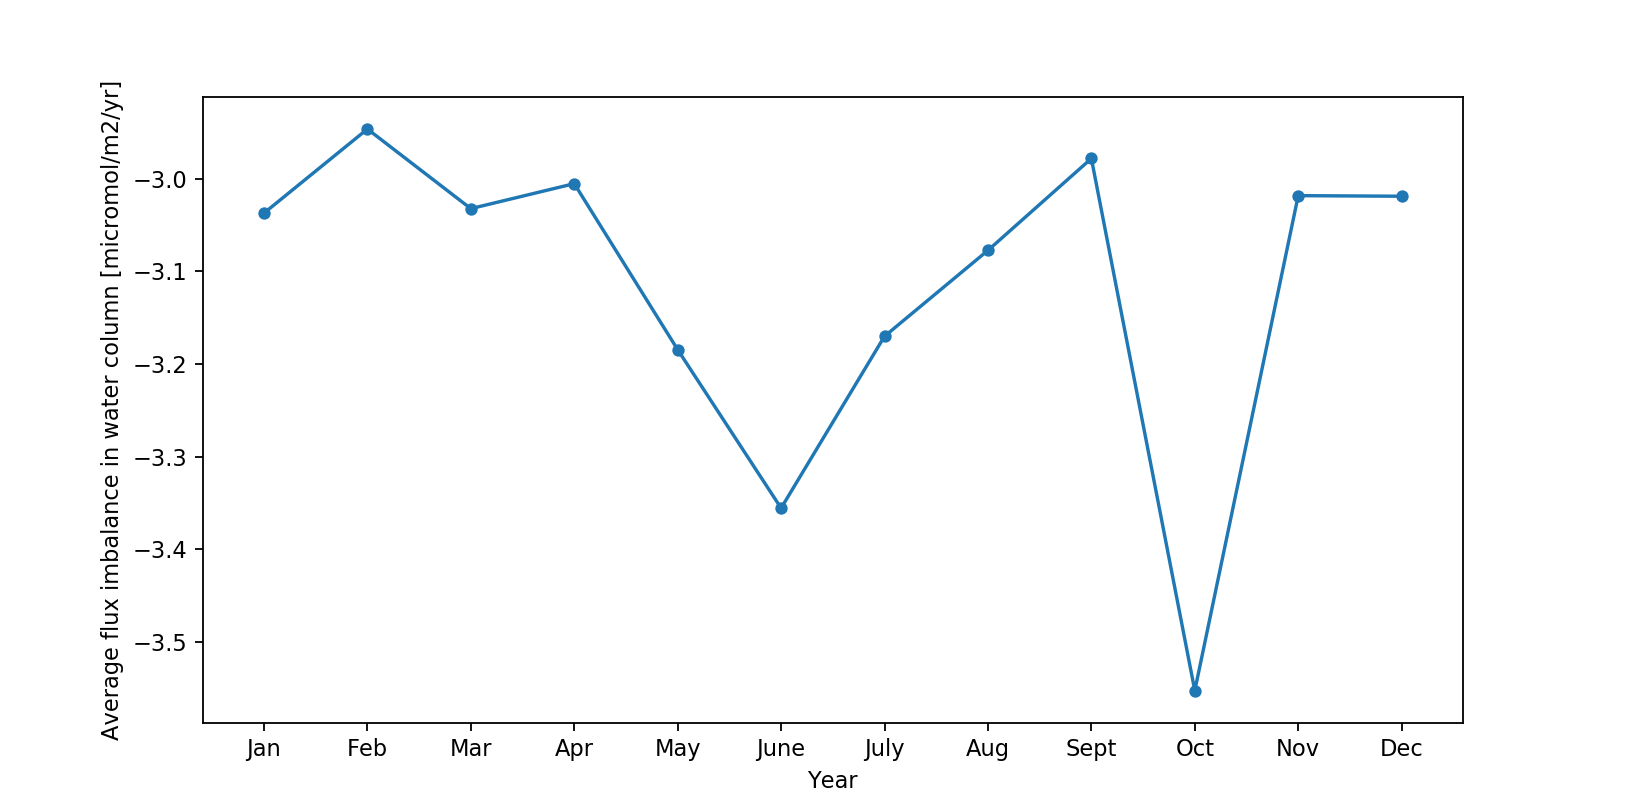

Text(0, 0.5, 'Average flux imbalance in water column [micromol/m2/yr]')

In [70]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.plot(months, average_balance*1e6)
ax.scatter(months, average_balance*1e6, s=20)

ax.set_xlabel('Year')
ax.set_ylabel('Average flux imbalance in water column [micromol/m2/yr]')

In [27]:
riv_change = (ts_riv[1:-1]-ts_riv[0:-2])*100/np.amax(np.abs(ts_riv[1:-1]-ts_riv[0:-2]))
sed_change = (ts_sed[1:-1]-ts_sed[0:-2])*100/np.amax(np.abs(ts_sed[1:-1]-ts_sed[0:-2]))
atm_change = (ts_atm[1:-1]-ts_atm[0:-2])*100/np.amax(np.abs(ts_atm[1:-1]-ts_atm[0:-2]))
ice_change = (ts_ice[1:-1]-ts_ice[0:-2])*100/np.amax(np.abs(ts_ice[1:-1]-ts_ice[0:-2]))
red_change = (ts_red[1:-1]-ts_red[0:-2])*100/np.amax(np.abs(ts_red[1:-1]-ts_red[0:-2]))
oxi_change = (ts_oxi[1:-1]-ts_oxi[0:-2])*100/np.amax(np.abs(ts_oxi[1:-1]-ts_oxi[0:-2]))

In [29]:
riv_change = ts_riv/np.amax(np.abs(ts_riv))
sed_change = ts_sed/np.amax(np.abs(ts_sed))
atm_change = ts_atm/np.amax(np.abs(ts_atm))
ice_change = ts_ice/np.amax(np.abs(ts_ice))
red_change = ts_red/np.amax(np.abs(ts_red))
oxi_change = ts_oxi/np.amax(np.abs(ts_oxi))

<IPython.core.display.Javascript object>


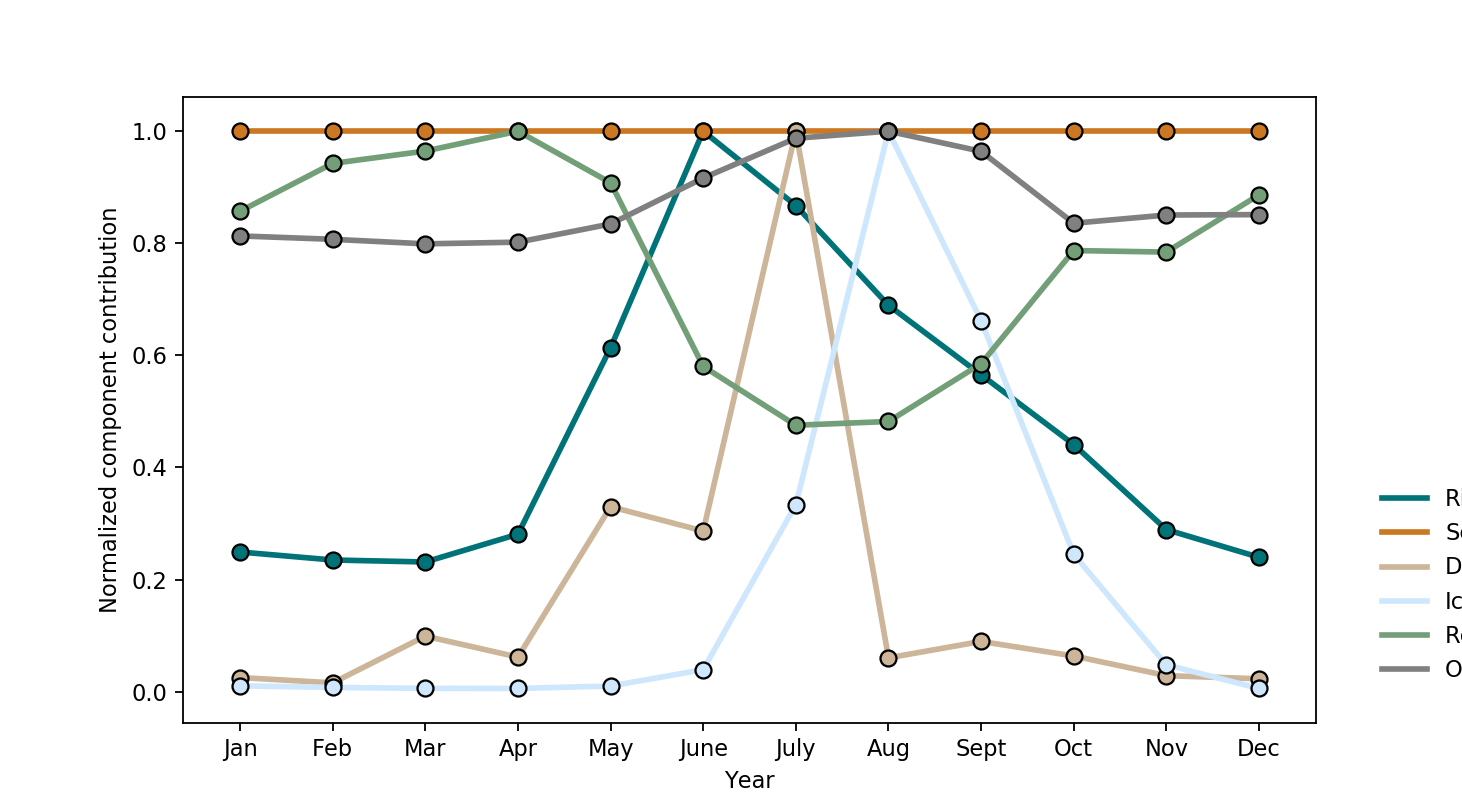

Text(0, 0.5, 'Normalized component contribution')

In [30]:
fig, ax = plt.subplots(1,1, figsize=(9,5))

ax.plot(months, riv_change, color=colors[1], linewidth=2.5, label='Riverine'   , zorder=1)
ax.plot(months, sed_change, color=colors[3], linewidth=2.5, label='Sedimentary', zorder=1)
ax.plot(months, atm_change, color=colors[0], linewidth=2.5, label='Dust'       , zorder=1)
ax.plot(months, ice_change, color=colors[4], linewidth=2.5, label='Ice'        , zorder=1)
ax.plot(months, red_change, color=colors[2], linewidth=2.5, label='Reduction'  , zorder=1)
ax.plot(months, oxi_change, color='gray'   , linewidth=2.5, label='Oxidation'  , zorder=1)

ax.scatter(months, riv_change, color=colors[1], edgecolor='k', s=50, zorder=2)
ax.scatter(months, sed_change, color=colors[3], edgecolor='k', s=50, zorder=2)
ax.scatter(months, atm_change, color=colors[0], edgecolor='k', s=50, zorder=2)
ax.scatter(months, ice_change, color=colors[4], edgecolor='k', s=50, zorder=2)
ax.scatter(months, red_change, color=colors[2], edgecolor='k', s=50, zorder=2)
ax.scatter(months, oxi_change, color='gray'   , edgecolor='k', s=50, zorder=2)

ax.legend(loc=(1.05, 0.05), frameon=False)
ax.set_xlabel('Year')
ax.set_ylabel('Normalized component contribution')

## Map of surface with the most important component

In [36]:
def comp_importance(month, redox=True):
    
    riv_imp = np.ma.masked_where((riv[month,:,:] < sed[month,:,:]), riv[month,:,:])
    riv_imp = np.ma.masked_where((riv_imp[:,:]   < atm[month,:,:]), riv_imp[:,:])
    riv_imp = np.ma.masked_where((riv_imp[:,:]   < ice[month,:,:]), riv_imp[:,:])
    sed_imp = np.ma.masked_where((sed[month,:,:] < riv[month,:,:]), sed[month,:,:])
    sed_imp = np.ma.masked_where((sed_imp[:,:]   < atm[month,:,:]), sed_imp[:,:])
    sed_imp = np.ma.masked_where((sed_imp[:,:]   < ice[month,:,:]), sed_imp[:,:])
    ice_imp = np.ma.masked_where((ice[month,:,:] < sed[month,:,:]), ice[month,:,:])
    ice_imp = np.ma.masked_where((ice_imp[:,:]   < atm[month,:,:]),  ice_imp[:,:])
    ice_imp = np.ma.masked_where((ice_imp[:,:]   < riv[month,:,:]),  ice_imp[:,:])
    atm_imp = np.ma.masked_where((atm[month,:,:] < sed[month,:,:]), atm[month,:,:])
    atm_imp = np.ma.masked_where((atm_imp[:,:]   < riv[month,:,:]),  atm_imp[:,:])
    atm_imp = np.ma.masked_where((atm_imp[:,:]   < ice[month,:,:]),  atm_imp[:,:])
    
    if redox:
        riv_imp = np.ma.masked_where((riv_imp[:,:]   < red[month,0,:,:]), riv_imp[:,:])
        riv_imp = np.ma.masked_where((riv_imp[:,:]   < oxi[month,0,:,:]), riv_imp[:,:])
        sed_imp = np.ma.masked_where((sed_imp[:,:]   < red[month,0,:,:]), sed_imp[:,:])
        sed_imp = np.ma.masked_where((sed_imp[:,:]   < oxi[month,0,:,:]), sed_imp[:,:])

        oxi_imp = np.ma.masked_where((oxi[month,0,:,:] < sed[month,:,:]), oxi[month,0,:,:])
        oxi_imp = np.ma.masked_where((oxi_imp[:,:]     < atm[month,:,:]), oxi_imp[:,:])
        oxi_imp = np.ma.masked_where((oxi_imp[:,:]     < ice[month,:,:]), oxi_imp[:,:])
        oxi_imp = np.ma.masked_where((oxi_imp[:,:]     < red[month,0,:,:]), oxi_imp[:,:])
        oxi_imp = np.ma.masked_where((oxi_imp[:,:]     < riv[month,:,:]), oxi_imp[:,:])

        red_imp = np.ma.masked_where((red[month,0,:,:] < sed[month,:,:]), red[month,0,:,:])
        red_imp = np.ma.masked_where((red_imp[:,:]     < atm[month,:,:]), red_imp[:,:])
        red_imp = np.ma.masked_where((red_imp[:,:]     < ice[month,:,:]), red_imp[:,:])
        red_imp = np.ma.masked_where((red_imp[:,:]     < oxi[month,0,:,:]), red_imp[:,:])
        red_imp = np.ma.masked_where((red_imp[:,:]     < riv[month,:,:]), red_imp[:,:])

        ice_imp = np.ma.masked_where((ice_imp[:,:]   < red[month,0,:,:]),  ice_imp[:,:])
        ice_imp = np.ma.masked_where((ice_imp[:,:]   < oxi[month,0,:,:]),  ice_imp[:,:])

        atm_imp = np.ma.masked_where((atm_imp[:,:]   < red[month,0,:,:]),  atm_imp[:,:])
        atm_imp = np.ma.masked_where((atm_imp[:,:]   < oxi[month,0,:,:]),  atm_imp[:,:])
    else:
        red_imp = np.empty(red[month,0,:,:].shape)
        oxi_imp = np.empty(oxi[month,0,:,:].shape)
        
    return riv_imp, sed_imp, ice_imp, atm_imp, oxi_imp, red_imp

In [37]:
month   = 8

In [38]:
riv_imp, sed_imp, ice_imp, atm_imp, oxi_imp, red_imp = comp_importance(month)

In [63]:
riv_imp.shape

(700, 640)

### Seasonal cycle:

In [92]:
def plot_year_importance(fig, ax, proj1, redox=True):
    
    x, y = proj1(lon_model, lat_model)
    
    axes=[ax[0,0], ax[0,1], ax[0,2], ax[0,3], \
          ax[1,0], ax[1,1], ax[1,2], ax[1,3], \
          ax[2,0], ax[2,1], ax[2,2], ax[2,3]]
    
    for month in range(0,12):
        riv_imp, sed_imp, ice_imp, atm_imp, oxi_imp, red_imp = comp_importance(month, redox)
        
        if redox:
            proj1.scatter(x[~red_imp.mask], y[~red_imp.mask], s=0.01, c=colors[2], ax=axes[month], zorder=2)
            proj1.scatter(x[~oxi_imp.mask], y[~oxi_imp.mask], s=0.01, c='gray', ax=axes[month], zorder=2)
        
        proj1.scatter(x[~ice_imp.mask], y[~ice_imp.mask], s=0.01, c=colors[4], ax=axes[month], zorder=2)
        proj1.scatter(x[~sed_imp.mask], y[~sed_imp.mask], s=0.01, c=colors[3], ax=axes[month], zorder=2)
        proj1.scatter(x[~atm_imp.mask], y[~atm_imp.mask], s=0.01, c=colors[0], ax=axes[month], zorder=2)
        proj1.scatter(x[~riv_imp.mask], y[~riv_imp.mask], s=0.01, c=colors[1], ax=axes[month], zorder=2)
                    
#         proj1.plot(x[~atm_imp.mask], y[~atm_imp.mask],'.', markersize=0.01,c=colors[0], ax=axes[month], zorder=2)
#         proj1.plot(x[~riv_imp.mask], y[~riv_imp.mask],'.', markersize=0.01, c=colors[1], ax=axes[month], zorder=2)
#         proj1.plot(x[~sed_imp.mask], y[~sed_imp.mask],'.', markersize=0.01, c=colors[3], ax=axes[month], zorder=2)
#         proj1.plot(x[~ice_imp.mask], y[~ice_imp.mask],'.', markersize=0.01, c=colors[4], ax=axes[month], zorder=2)
        
        proj1.contourf(x, y, land_mask[0,1480:2180,160:800], vmax=0.3, \
                       cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=3)
        axes[month].set_title(months[month])
    
    return

<IPython.core.display.Javascript object>


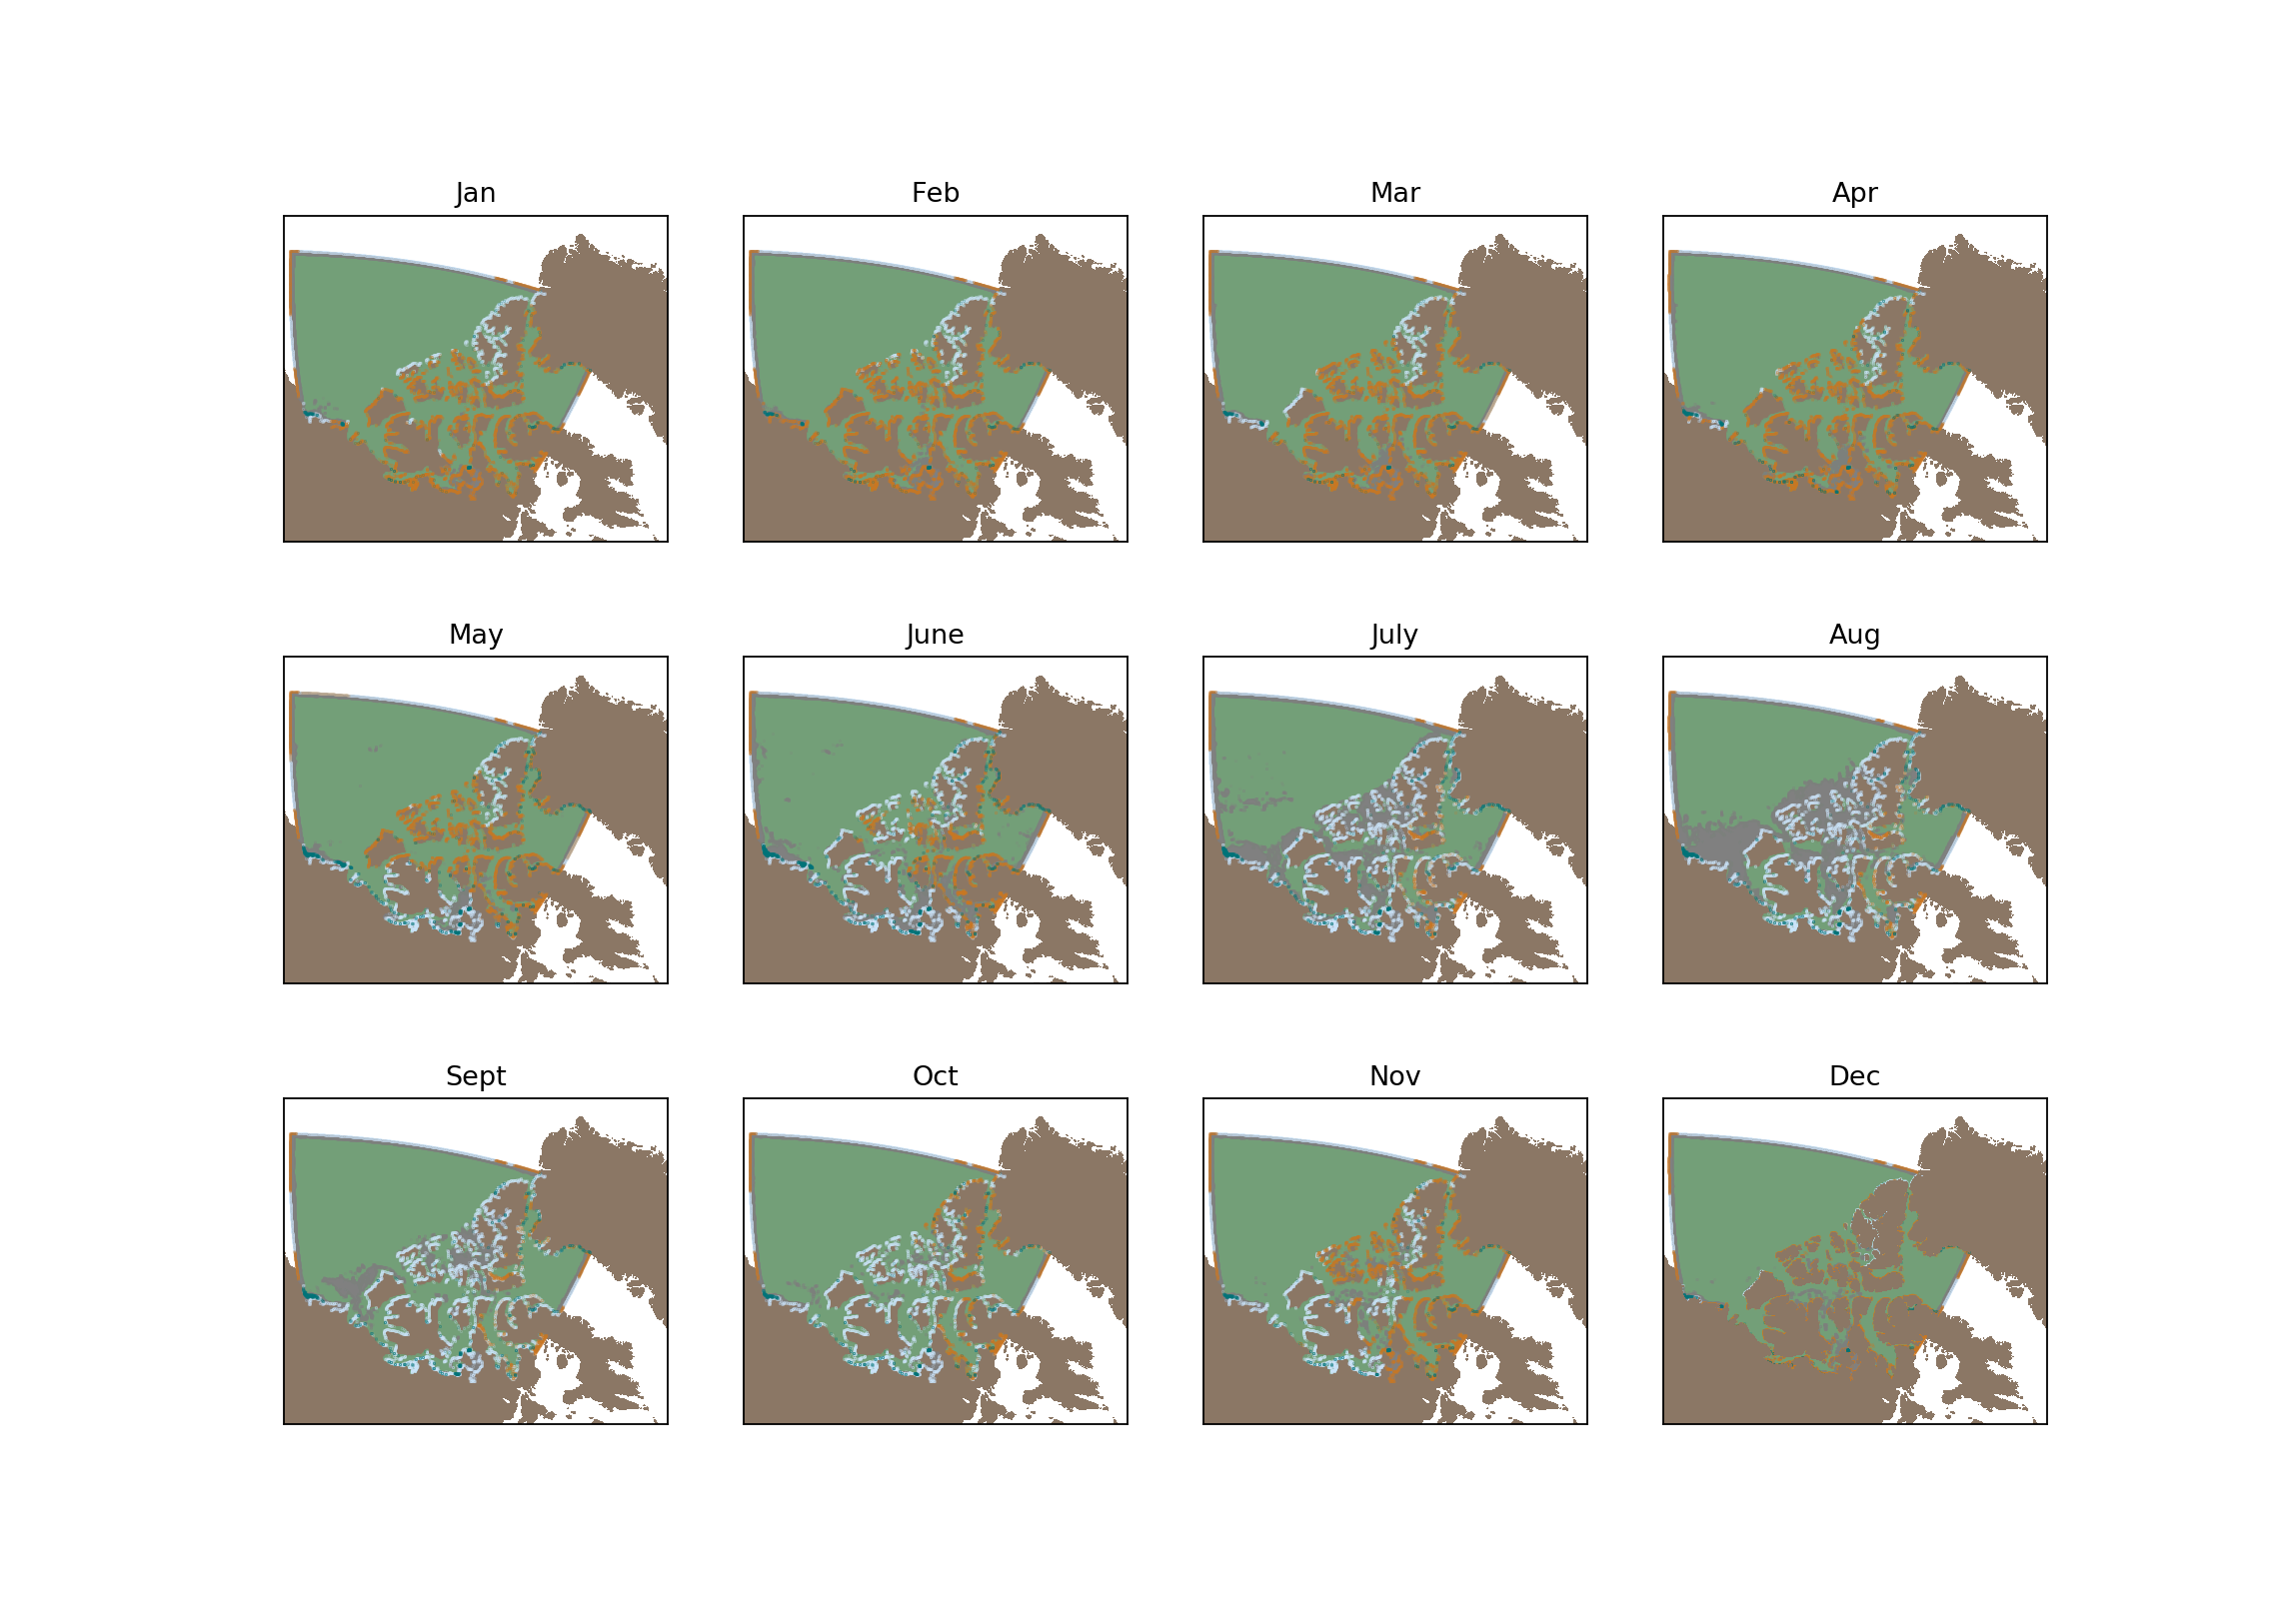

In [95]:
fig, ax, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/analysis-brogalla/maps/surface-Mn_subplots.pickle','rb'))

plot_year_importance(fig, ax, proj1, redox=True)

# proj1.plot(0,0,'.', markersize=20, c=colors[0], label='Dust from atmosphere')
# proj1.plot(0,0,'.', markersize=20, c=colors[1], label='River')
# proj1.plot(0,0,'.', markersize=20, c=colors[2], label='Scavenging')
# proj1.plot(0,0,'.', markersize=20, c=colors[3], label='Sediment')
# proj1.plot(0,0,'.', markersize=20, c=colors[4], label='Ice')

# ax[2,3].legend(loc=(1.01, 0.05), fontsize=14, frameon=False)

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/seasonal-components.png', bbox_inches='tight', dpi=300)

<IPython.core.display.Javascript object>


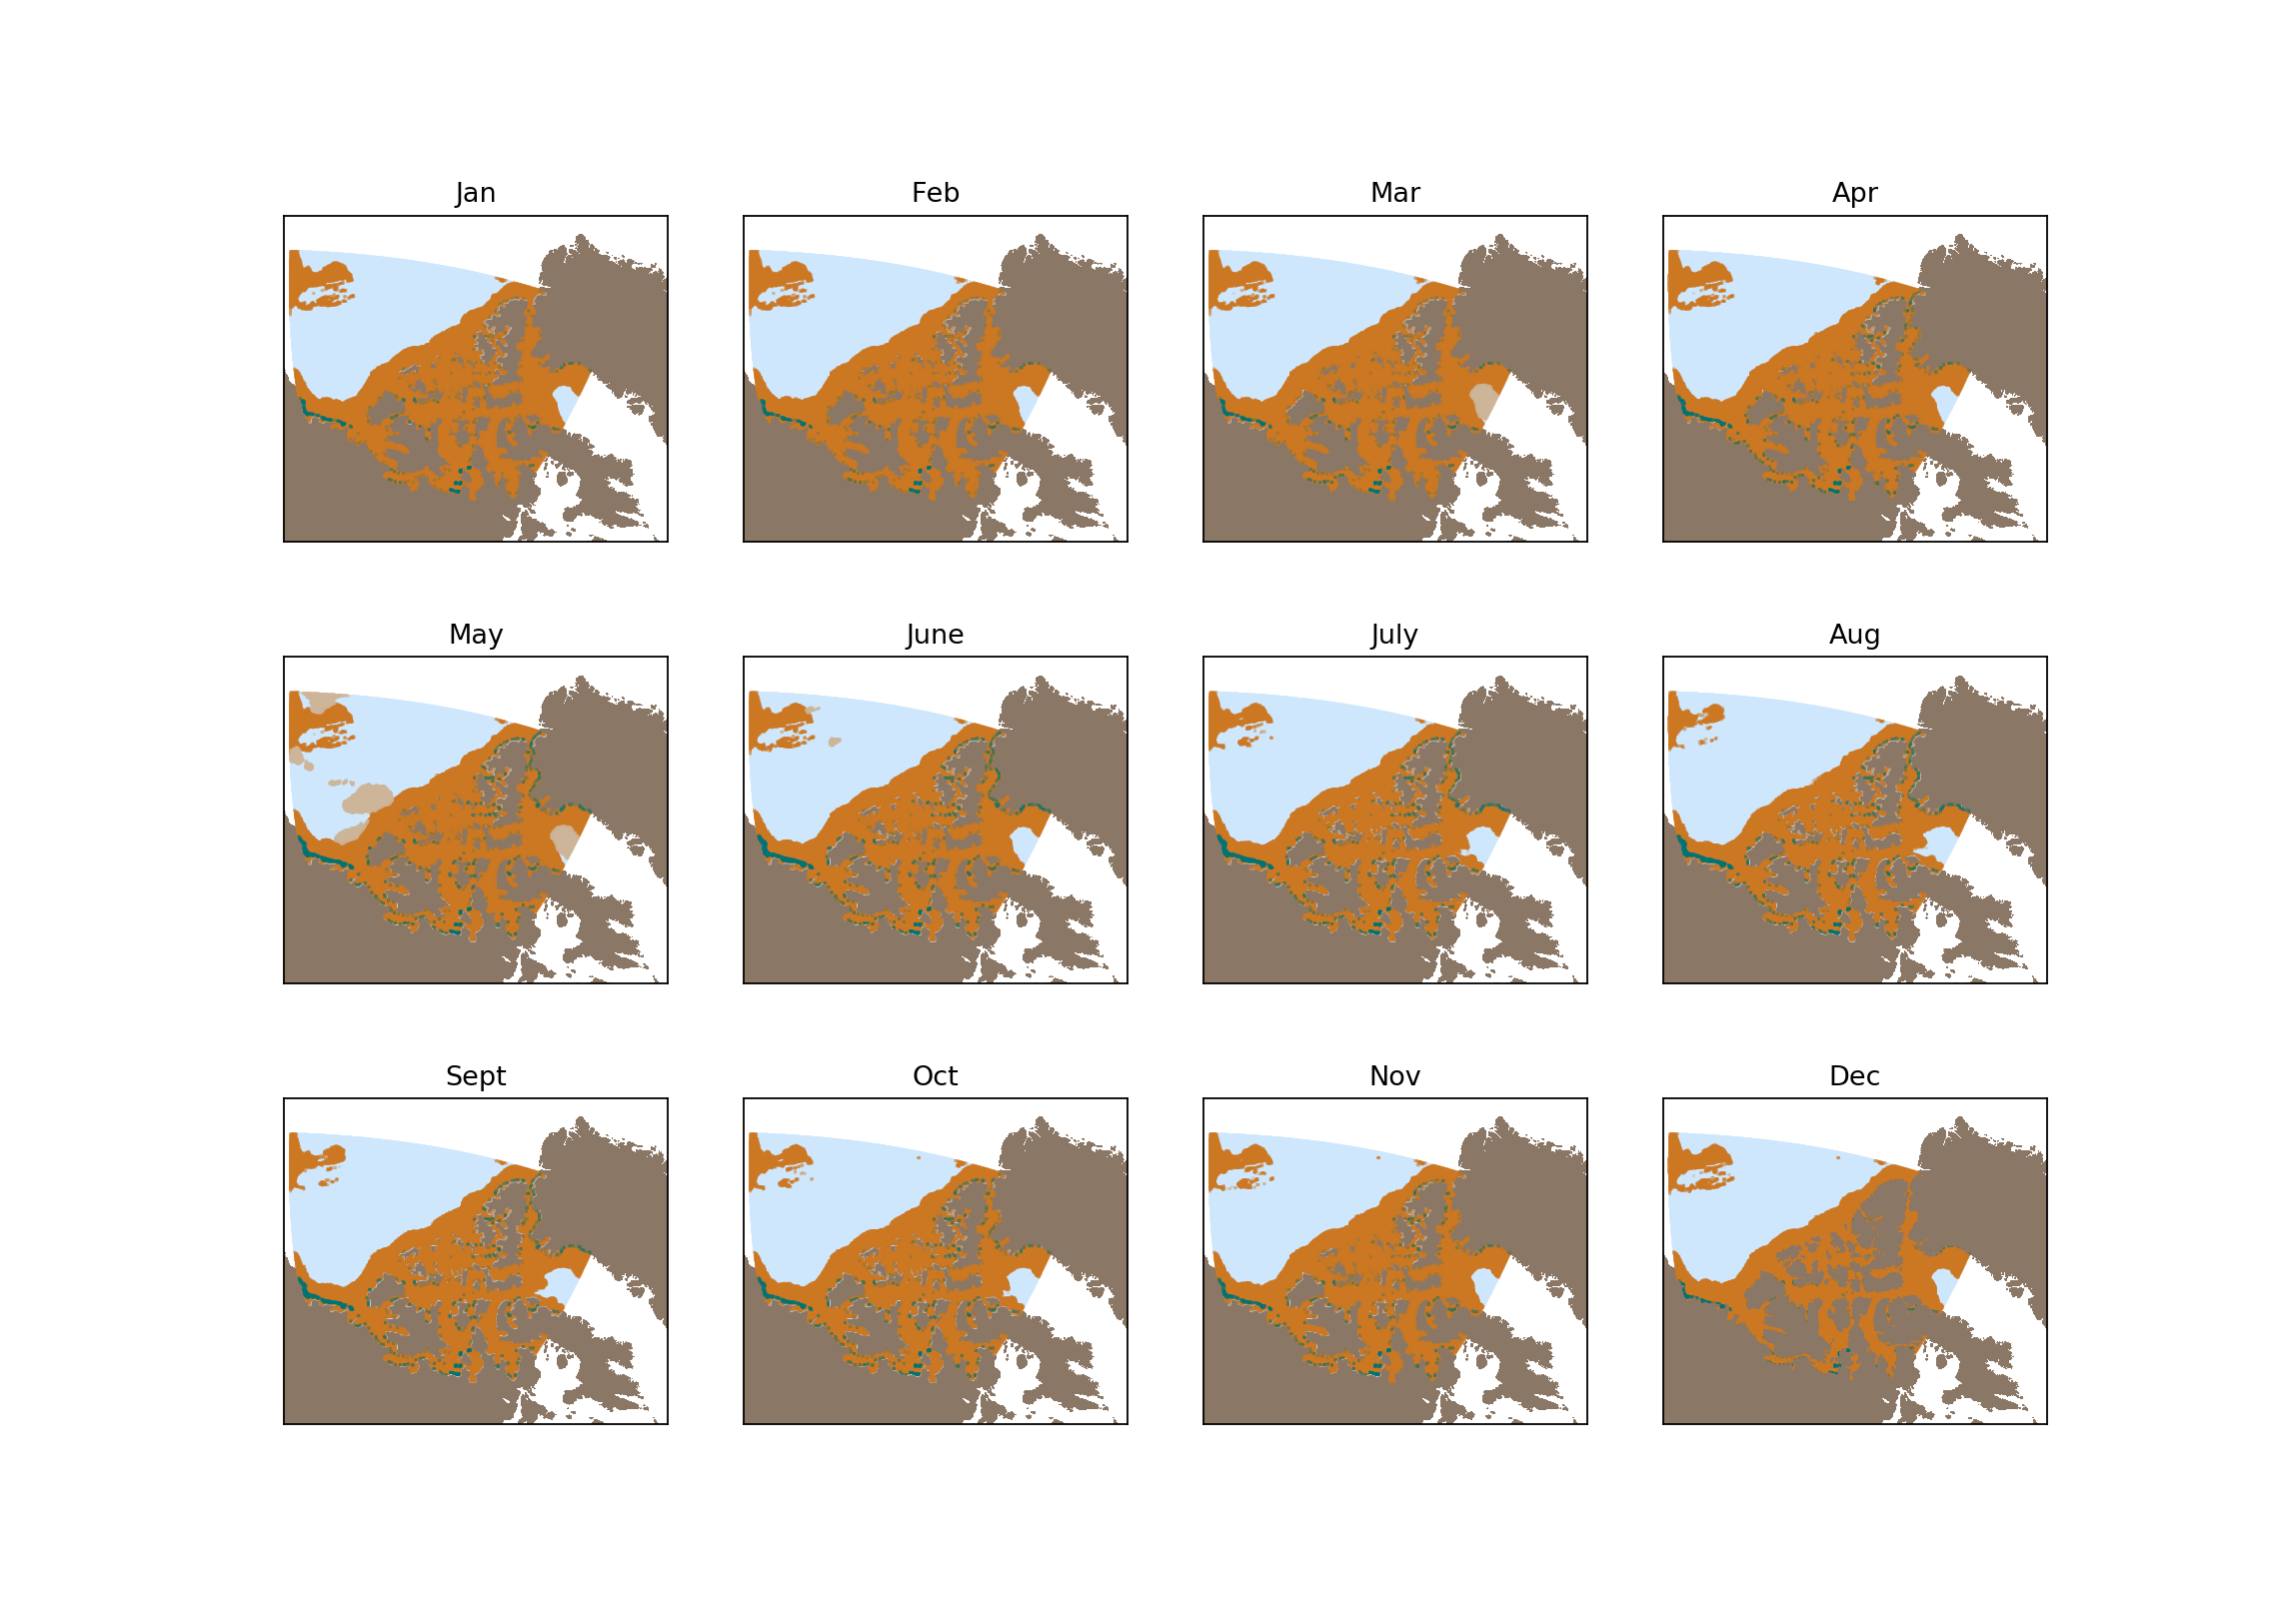

In [96]:
fig, ax, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/analysis-brogalla/maps/surface-Mn_subplots.pickle','rb'))

plot_year_importance(fig, ax, proj1, redox=False)

# proj1.plot(0,0,'.', markersize=20, c=colors[0], label='Dust from atmosphere')
# proj1.plot(0,0,'.', markersize=20, c=colors[1], label='River')
# proj1.plot(0,0,'.', markersize=20, c=colors[2], label='Scavenging')
# proj1.plot(0,0,'.', markersize=20, c=colors[3], label='Sediment')
# proj1.plot(0,0,'.', markersize=20, c=colors[4], label='Ice')

# ax[2,3].legend(loc=(1.01, 0.05), fontsize=14, frameon=False)

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/seasonal-components.png', bbox_inches='tight', dpi=300)